In [1]:
pip install scikit-lego

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 219.6/219.6 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 208.1/208.1 kB 12.4 MB/s eta 0:00:00


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score, silhouette_samples, rand_score, adjusted_rand_score

In [3]:
df = pd.read_csv("hf://datasets/maharshipandya/spotify-tracks-dataset/dataset.csv")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [4]:
#Checking loading of data frame
df.head(5)

,Unnamed: 0,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,...,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic
1,1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,...,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic
2,2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,...,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic
3,3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,...,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic
4,4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,...,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic


## Apply cleaning function

Going to look at clustering popular music genres (Pop, Rock,Hip-Hop,Electronic,Indie, Country, Jazz, Latin, Reggae, Blues)


1.   pop
2.   rock
3. hip-hop
4. electronic
5. indie
6. blues
7. county
8. jazz
9. latin
10. reggae



In [5]:
# Data Cleaning Function (modify)
def clean_data(df):
  clean_df = df.copy()
  clean_df = clean_df.drop('Unnamed: 0', axis=1, errors='ignore')
  clean_df = clean_df.dropna()

  #Encode explicit column (binary encoding)
  clean_df['explicit'] = clean_df['explicit'].astype(int)

  # Drop track_id, artisits,album_name
  clean_df = clean_df.drop(['track_id', 'artists', 'album_name'], axis=1)

  # Lets look at clustering only track_genre (Pop, Rock,Hip-Hop,Electronic,Indie, blues, Country, Jazz, Latin, Reggae)
  genres_to_keep = ['pop', 'rock', 'hip-hop', 'electronic', 'indie', 'blues ','country', 'jazz', 'latin', 'reggae']
  clean_df = clean_df[clean_df['track_genre'].isin(genres_to_keep)]
  track_genre_mapping = {'pop': 0, 'rock': 1, 'hip-hop': 2, 'electronic': 3, 'indie': 4, 'blues ': 5, 'country': 6, 'jazz': 7, 'latin': 8, 'reggae': 9}
  clean_df['track_genre'] = clean_df['track_genre'].map(track_genre_mapping)

  return clean_df

# Apply the function to the DataFrame
spotify_clean = clean_data(df)

In [6]:
#Looking at cleaned data frame
spotify_clean.sample(15)

,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
57664,Duur Hai Wo,43,285357,0,0.357,0.316,6,-10.467,1,0.0311,0.42400,0.000730,0.1000,0.240,159.861,3,4
57610,Faasla,51,199735,0,0.739,0.390,11,-12.118,0,0.0918,0.04750,0.132000,0.0732,0.285,91.961,4,4
91432,Hermosa Ingrata,0,181840,0,0.729,0.764,9,-6.138,0,0.0452,0.20100,0.000598,0.0807,0.964,94.017,4,1
32550,I Wanna Know,56,206727,0,0.432,0.850,10,-4.417,1,0.0771,0.50100,0.000007,0.2030,0.109,82.607,4,3
91105,Softcore,86,206280,0,0.575,0.568,9,-5.509,0,0.0300,0.04840,0.000417,0.2860,0.370,93.986,4,1
67980,Suena El Dembow,1,195760,0,0.690,0.858,0,-4.431,1,0.0529,0.18900,0.000000,0.1130,0.755,91.884,4,8
51279,Pind Da Riwaaz,62,188181,1,0.904,0.767,9,-1.909,1,0.2320,0.04570,0.000009,0.0720,0.656,87.989,4,2
91109,I WANNA BE YOUR SLAVE,83,173346,1,0.750,0.608,1,-4.008,1,0.0387,0.00165,0.000000,0.1780,0.958,132.507,4,1
64018,Christmas Calling (Jolly Jones),0,200461,0,0.430,0.543,8,-6.296,1,0.0367,0.46300,0.000523,0.0928,0.354,143.912,4,7
91454,THE LONELIEST,85,247067,0,0.519,0.595,2,-5.001,1,0.0283,0.00151,0.000000,0.0762,0.237,129.786,4,1


In [7]:
#Split into X and y
X = spotify_clean.drop('track_genre', axis=1)
y = spotify_clean['track_genre']

In [9]:
# Normalize data after the 1st column
ss = StandardScaler()
X_scaled = ss.fit_transform(X[X.columns[1:]])

# Find cluster centers
kmeans = KMeans(n_clusters=10, random_state=42)
y_kmeans = kmeans.fit_predict(X_scaled)
kmeans.cluster_centers_

array([[ 9.90441942e-01,  6.22187912e-01, -3.42560042e-01,
        -2.63030831e-01, -3.30564217e-01, -1.35561199e-01,
        -1.87975096e-01, -6.10137979e-03, -3.94548348e-01,
         2.11125942e-01, -1.98369328e-01, -2.68633467e-01,
        -6.71527329e-01, -3.00032008e-01,  1.80904060e-01],
       [ 1.97070266e-01,  1.60773155e-01, -2.05762212e-01,
        -8.09643516e-02,  4.71484625e-01,  8.11444874e-02,
         2.07712509e-01, -1.11089676e-01,  9.73309006e-02,
        -2.24187751e-01, -6.20058429e-02,  3.55807431e+00,
         2.59820399e-01,  2.36361837e-01,  1.88269996e-01],
       [ 4.93764857e-01,  8.84316941e-01, -3.09454035e-01,
        -6.80503063e-02, -2.06241967e-01,  9.76733955e-02,
        -8.77117654e-01, -2.35722339e-01, -2.89785380e-01,
         1.92832085e-02,  4.14044488e+00, -2.05582133e-01,
        -9.88641099e-01, -5.52609332e-02,  1.08728734e-01],
       [-2.02066547e-01, -8.55940106e-02, -2.51160814e-01,
        -1.11736453e+00, -1.44776004e+00, -1.68329800

## Visualizing Clusters and Cluster Centers

[[ 9.90441942e-01  6.22187912e-01 -3.42560042e-01 -2.63030831e-01
  -3.30564217e-01 -1.35561199e-01 -1.87975096e-01 -6.10137979e-03
  -3.94548348e-01  2.11125942e-01 -1.98369328e-01 -2.68633467e-01
  -6.71527329e-01 -3.00032008e-01  1.80904060e-01]
 [ 1.97070266e-01  1.60773155e-01 -2.05762212e-01 -8.09643516e-02
   4.71484625e-01  8.11444874e-02  2.07712509e-01 -1.11089676e-01
   9.73309006e-02 -2.24187751e-01 -6.20058429e-02  3.55807431e+00
   2.59820399e-01  2.36361837e-01  1.88269996e-01]
 [ 4.93764857e-01  8.84316941e-01 -3.09454035e-01 -6.80503063e-02
  -2.06241967e-01  9.76733955e-02 -8.77117654e-01 -2.35722339e-01
  -2.89785380e-01  1.92832085e-02  4.14044488e+00 -2.05582133e-01
  -9.88641099e-01 -5.52609332e-02  1.08728734e-01]
 [-2.02066547e-01 -8.55940106e-02 -2.51160814e-01 -1.11736453e+00
  -1.44776004e+00 -1.68329800e-01 -1.11132024e+00  1.82344494e-01
  -4.46954239e-01  1.36236775e+00 -1.38510358e-01 -1.09090423e-01
  -8.49187544e-01 -7.30124727e-03 -3.17645956e+00]
 [ 2

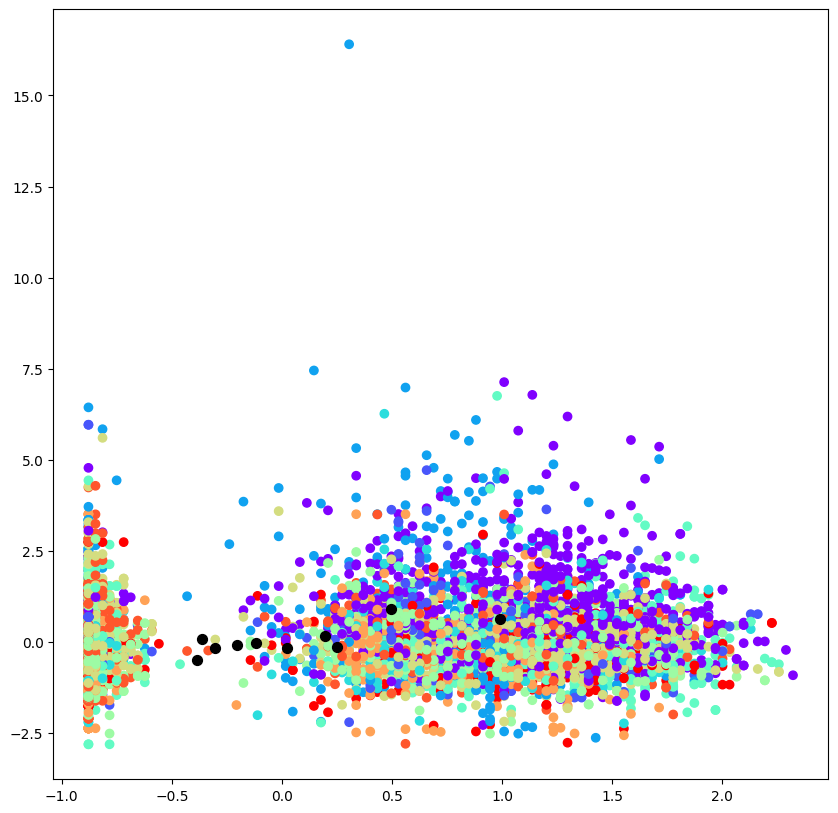

In [15]:
# Find centroids
centroids = kmeans.cluster_centers_
print(centroids)

# Scatter plot showing clusters ???
plt.figure(figsize=(10,10))

plt.scatter(X_scaled[:,0], X_scaled[:,1], c = y_kmeans, cmap = 'rainbow')
plt.scatter(centroids[:, 0], centroids[:, 1], c='black', s=50)
plt.show()

In [18]:
# prompt: i want the dimensions of spotify_clean

spotify_clean.shape

(9000, 17)

In [24]:
genres = spotify_clean[['track_genre']]
print(kmeans.labels_)

label = pd.DataFrame(kmeans.labels_.reshape(9000,1), columns=['labels'])
combined = pd.concat([genres, label], axis=1)

list(combined.groupby('labels')['track_genre'].unique())

[0 8 8 ... 1 1 1]


[array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([nan])]

## Cross Validation to determine number of clusters

We do not need to cross validate because we know we have 10 clusters because we are choosing to do it based on 10 genres.

## PCA and/or Clustering

If you apply PCA to your data, include code, cumulative variability explained, and scree plot. Explain how you are using PCA in your project for dimensionality reduction or to learn structure in the data.

If you apply clustering, include code. quantitative metrics to evaluate clustering, and how you determined the number of clusters for your data and why. Explain how clustering helped you learn about the structure of data for your project.